In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate, RZGate
from qiskit.quantum_info import Clifford, PauliList

In [12]:
class ParametricCircuit:
    def __init__(self, n_qubits: int, n_layers: int, thetas: np.ndarray):
        self.n_qubits: int = n_qubits
        self.n_layers: int = n_layers
        self.thetas = thetas.reshape((4, 5 * n_qubits//2 - 4, n_layers))
        self.param_gate_label: int = 0
        self.label_index_dict: dict[str, int] = {}

        self.qc = QuantumCircuit(n_qubits)
        for i in range(self.n_layers):
            self._layer(self.thetas[:,:,i])
            self.qc.barrier()
    
    
    def _add_param_gate(self, gate_name: str, *args) -> None:
        getattr(self.qc, gate_name)(*args, label = str(self.param_gate_label))
        self.label_index_dict[str(self.param_gate_label)] = len(self.qc.data) - 1
        self.param_gate_label += 1

    def _two_qubit_gate(self, thetas: np.ndarray, qubit1: int, qubit2: int) -> None:
        self._add_param_gate("rx", thetas[0], qubit1)
        self._add_param_gate("rx", thetas[1], qubit2)
        self.qc.cx(qubit1, qubit2)
        self._add_param_gate("rz", thetas[2], qubit1)
        self._add_param_gate("rz", thetas[3], qubit2)
    
    def _layer(self, thetas: np.ndarray) -> None:
        i: int = 0  # Current column of used thetas
        def gate(q1: int, q2: int) -> None:
            "Applies the elementary _two_qubit_gate sweeping through thetas' columns"
            nonlocal i
            self._two_qubit_gate(thetas[:,i], q1, q2)
            i += 1
        
        def contiguous_qubits_gates(q: int) -> None:
            '''
            Args:
                q (int): Smallest qubit the bundle of gates is applied to. \\
                         e.g. contiguous_qubits_gates(2) applies to (2,3), (4,5), and (6,7)
            '''
            if q >= 0:
                gate(q, q+1)
            gate(q+2, q+3)
            if q + 5 <= self.n_qubits - 1:
                gate(q+4, q+5)

        def alternate_qubits_gates(q: int) -> None:
            gate(q, q + 2)
            gate(q + 1, q + 3)
        
        contiguous_qubits_gates(-2)
        for q in np.arange(0, self.n_qubits-2, 2):
            alternate_qubits_gates(q)
            contiguous_qubits_gates(q)

    @property
    def clifford_list(self) -> list[Clifford]:
        out: list[Clifford] = []
        gate = QuantumCircuit(self.n_qubits)
        for i in range(len(self.qc.data)):
            gate.data = [self.qc.data[i]]
            out.append(Clifford(gate))
        return out
    
    def get_labeled_gate(self, label: int | str, shift: float = 0) -> QuantumCircuit:
        index = self.label_index_dict[str(label)]
        old_instr = self.qc.data[index]

        if old_instr.operation.name == "rx":
            new_operation = RXGate(old_instr.params[0] + shift)
        if old_instr.operation.name == "rz":
            new_operation = RZGate(old_instr.params[0] + shift)

        # if shift != 0: gate_instruction.operation.params[0] += shift
        # out = QuantumCircuit(self.n_qubits)
        # out.data = [self.qc.data[index]]
        out = QuantumCircuit(self.n_qubits)
        out.append(new_operation, old_instr.qubits, old_instr.clbits)
        return out
    
    def get_labeled_clifford(self, label: int | str, shift: float = 0) -> Clifford:
        return Clifford(
            self.get_labeled_gate(label, shift)
        )

    @property
    def n_gates(self): return len(self.qc.data)

    @property
    def n_parameters(self): return np.prod(self.thetas.shape)



class CliffordList:
    def __init__(self, param_circ: ParametricCircuit):
        self.list: list[Clifford] = param_circ.clifford_list
        self.n_qubits: int = param_circ.n_qubits
        self.I: Clifford = Clifford.from_label("I" * param_circ.n_qubits)

        self.heads = self.build_heads()
        self.tails = self.build_tails()
    
    def build_heads(self) -> list[Clifford]:
        out = []
        op = self.I
        for gate in self.list:
            op = op.compose(gate)
            out.append(op)
        return out
    
    def build_tails(self) -> list[Clifford]:
        out = []
        op = self.I
        for gate in reversed(self.list):
            op = op.compose(gate, front = True)
            out.append(op)
        out.reverse()
        return out

class EvolvedPaulis:
    def __init__(self, op: PauliList, param_circ: ParametricCircuit):
        self.param_circ: ParametricCircuit = param_circ
        self.label_index_dict = self.param_circ.label_index_dict
        self.op: PauliList = op
        self.cliff_list: CliffordList = CliffordList(self.param_circ)

        self.plus_ops: dict[str, PauliList] = {}
        self.minus_ops: dict[str, PauliList] = {}
        self.evolve_op()
    
    def evolve_op(self) -> None:
        I = self.cliff_list.I
        shift = np.pi / 2
        for label, index in self.label_index_dict.items():
            head = self.cliff_list.heads[index - 1] if index > 0 else I
            gate_plus = self.param_circ.get_labeled_clifford(label, shift)
            gate_minus =  self.param_circ.get_labeled_clifford(label, -shift)
            tail = self.cliff_list.tails[index + 1] if index < self.param_circ.n_gates-1 else I

            clifford_plus = head.compose(gate_plus.compose(tail))
            clifford_minus = head.compose(gate_minus.compose(tail))

            self.plus_ops[label] = self.op.evolve(clifford_plus)
            self.minus_ops[label] = self.op.evolve(clifford_minus)

def random_thetas(shape: tuple[int]):
    possible_theta_values = np.pi / 2 * np.arange(4)
    return np.random.choice(possible_theta_values, shape)

In [13]:
n_q = 10
n_l = 3
np.random.seed(42)
thetas = np.zeros(4 * 21 * n_l)
param_circ = ParametricCircuit(n_q, n_l, thetas)

In [14]:
def sum_Z(n_qubits: int) -> PauliList:
    def char(i,j): return 'Z' if i == j else 'I'
    return PauliList([
        ''.join([char(i,n_qubits - j - 1) for i in range(n_qubits)])
        for j in range(n_qubits)
    ])

op = sum_Z(10)

evolved_ops = EvolvedPaulis(op, param_circ)


In [19]:
param_circ.clifford_list[-1] == Clifford.from_label("I" * n_q)

np.True_

In [17]:
evolved_ops.minus_ops

{'0': PauliList(['-IIIIIIIIIY', 'IIIIIIIIZI', '-IIIIIIIZIY', 'IIIIIIZZZI',
            'IIIIIZIZII', 'IIIIZZZIII', 'IIIZIZIIII', '-IIZZZIIIIY',
            '-IZIZIIIIIY', '-ZIZIIIIZZY']),
 '1': PauliList(['IIIIIIIIIZ', '-IIIIIIIIYI', 'IIIIIIIZIZ', '-IIIIIIZZYI',
            'IIIIIZIZII', 'IIIIZZZIII', 'IIIZIZIIII', 'IIZZZIIIIZ',
            'IZIZIIIIIZ', '-ZIZIIIIZYZ']),
 '2': PauliList(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZIZ', 'IIIIIIZZZI',
            'IIIIIZIZII', 'IIIIZZZIII', 'IIIZIZIIII', 'IIZZZIIIIZ',
            'IZIZIIIIIZ', 'ZIZIIIIZZZ']),
 '3': PauliList(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZIZ', 'IIIIIIZZZI',
            'IIIIIZIZII', 'IIIIZZZIII', 'IIIZIZIIII', 'IIZZZIIIIZ',
            'IZIZIIIIIZ', 'ZIZIIIIZZZ']),
 '4': PauliList(['IIIIIIIIIZ', 'IIIIIIIIZI', '-IIIIIIIYIZ', '-IIIIIIZYZI',
            '-IIIIIZIYII', 'IIIIZZZIII', 'IIIZIZIIII', 'IIZZZIIIIZ',
            'IZIZIIIIIZ', '-ZIZIIIIYZZ']),
 '5': PauliList(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZIZ', '-IIIIIIYZZI',

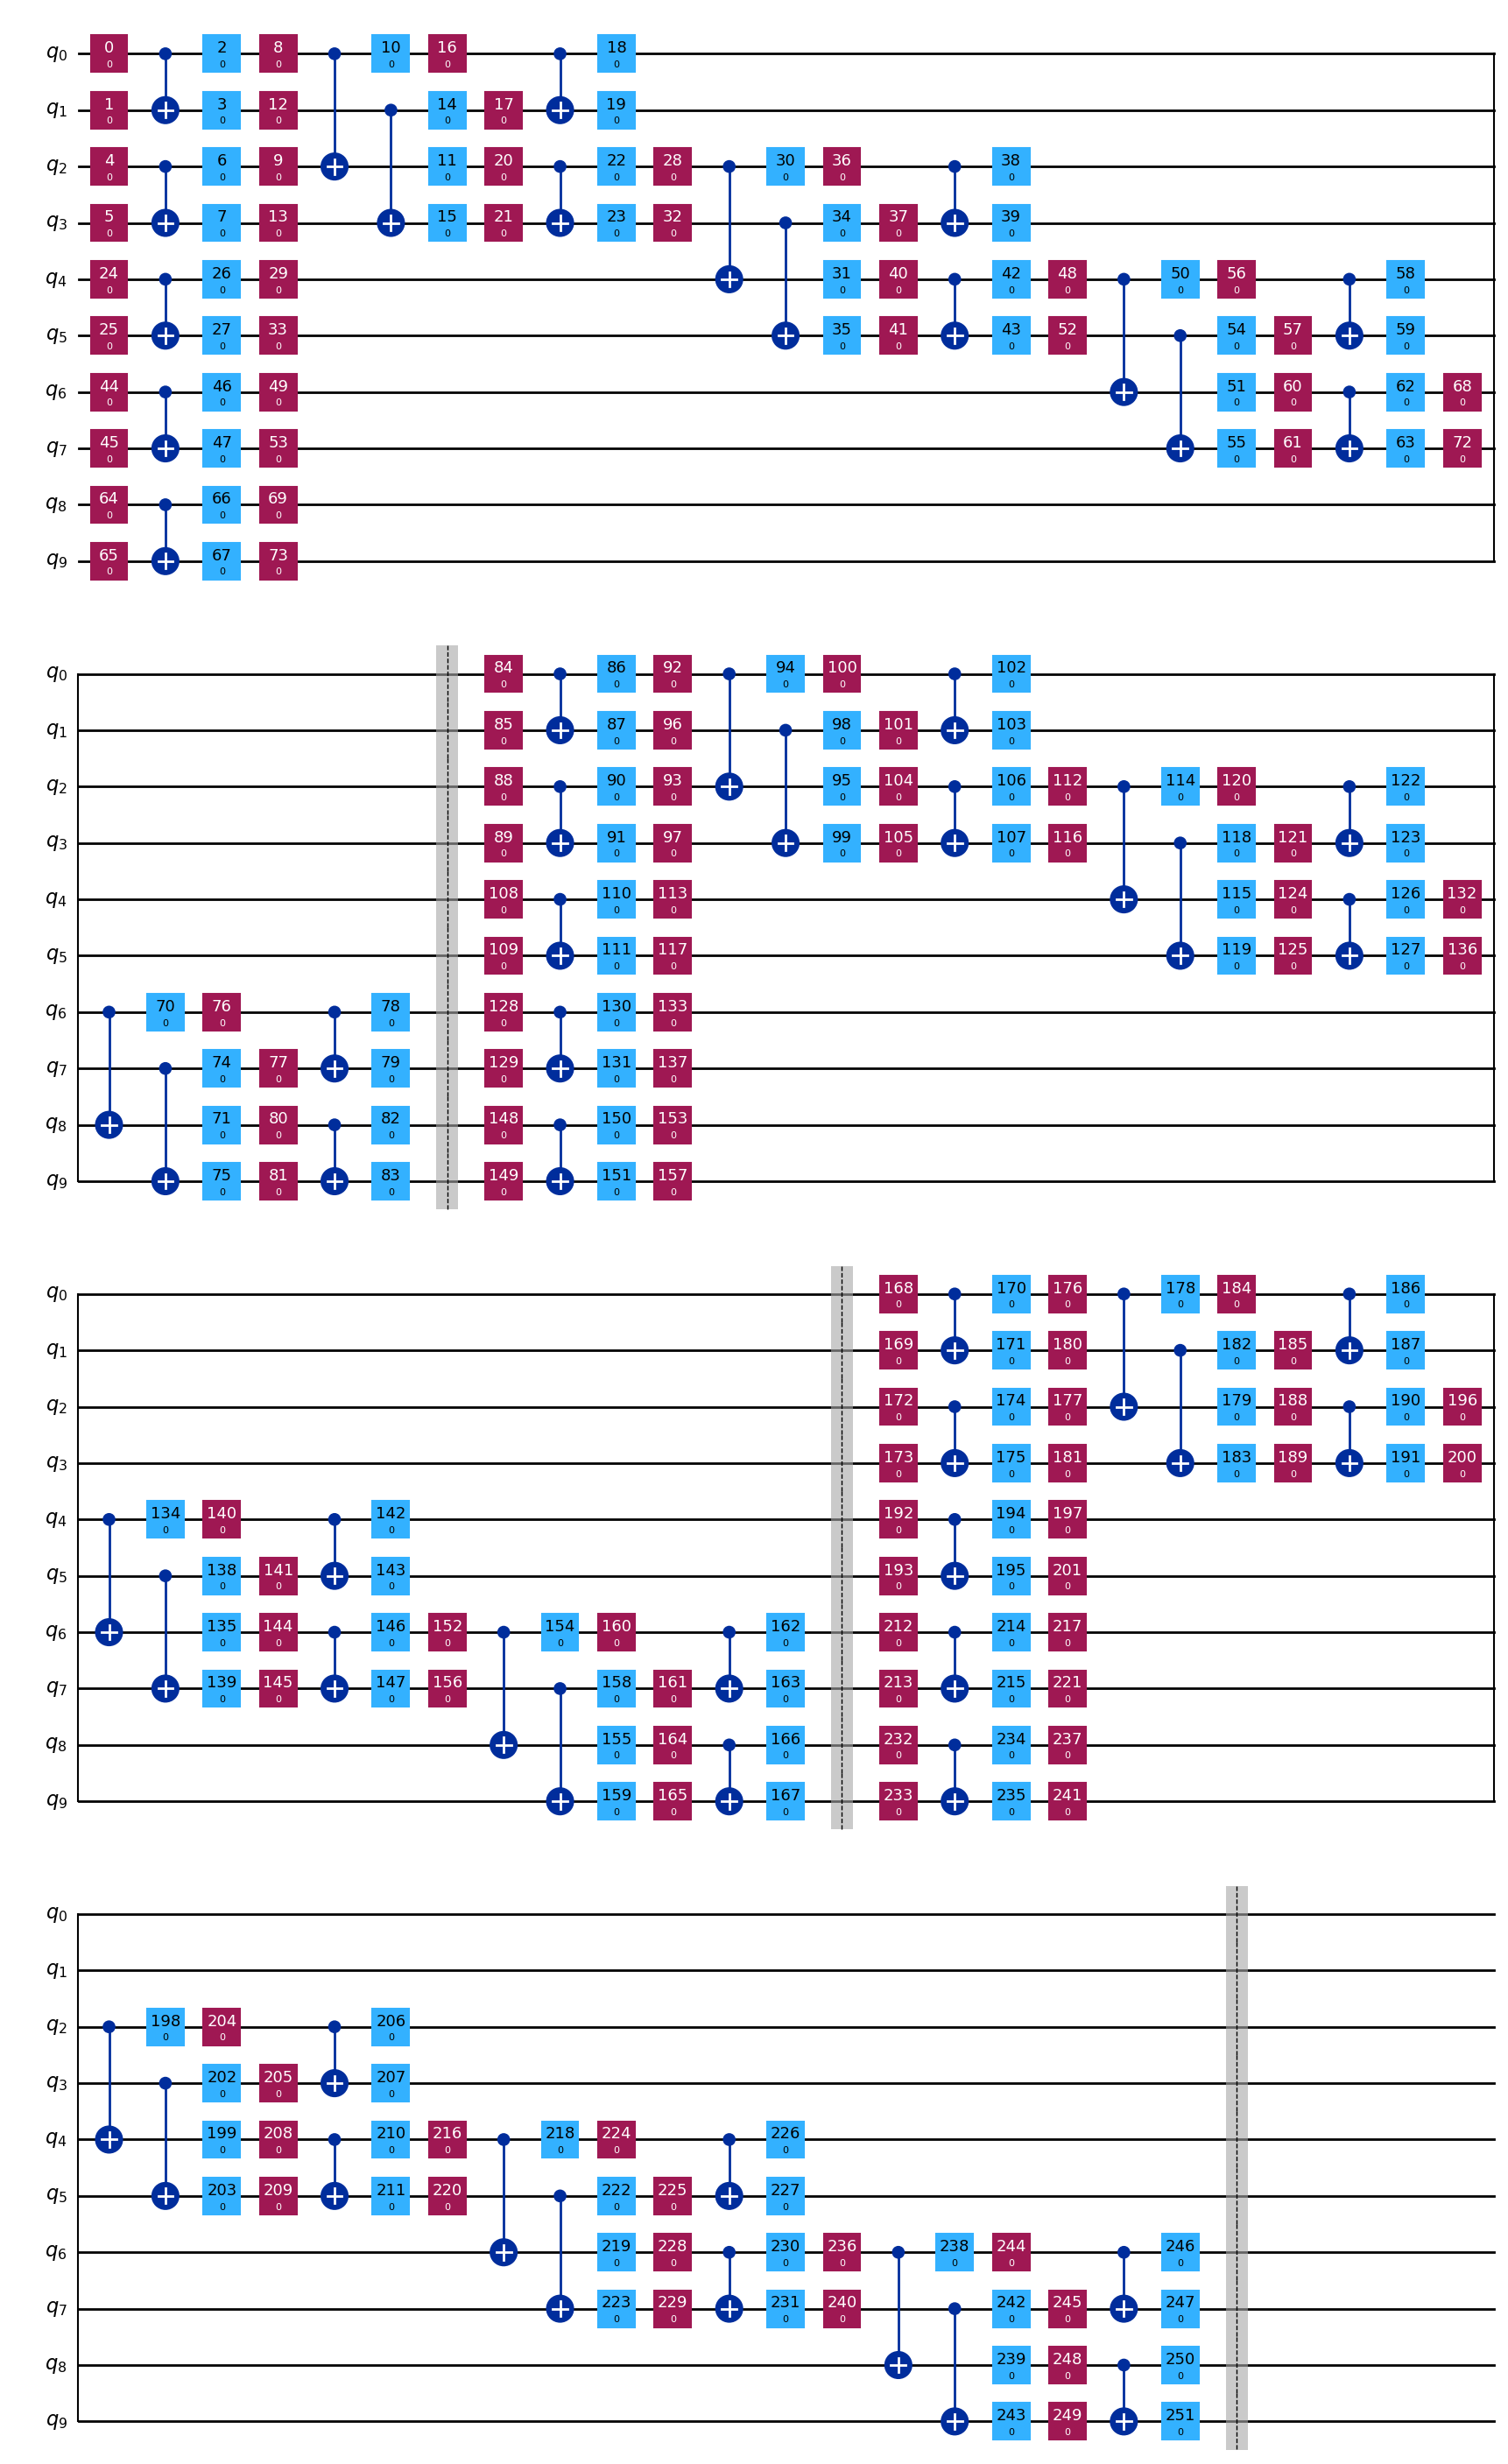

In [8]:
param_circ.qc.draw("mpl")

In [ ]:
print(param_circ.qc.data[0].operation.params)  # outputs [0.0]
param_circ.qc.data[0].operation.params[0] += np.pi / 2
print(param_circ.qc.data[0].operation.params)  # should output [pi/2] but outputs [0.0]

In [ ]:
cliff_list = CliffordList(param_circ)
print(cliff_list.heads[-1] == Clifford(param_circ.qc))
print(cliff_list.tails[0] == Clifford(param_circ.qc))

In [ ]:
index = 300
tmp_qc = QuantumCircuit(n_q)
tmp_qc.data = [param_circ.qc.data[index]]
cliff_list[300] == Clifford(tmp_qc)

In [ ]:
n_q = 4
qc = QuantumCircuit(n_q)
qc.rx(np.pi, 0, label = "0")
qc.cx(0, 1)
# qc.rz(np.pi/2, 1)
display(qc.draw("mpl"))
clifford = Clifford(qc)
qc.data

In [ ]:
op = PauliList(["ZIII", "IIIZ"])
op = op._evolve_clifford(clifford)
op

In [ ]:
op[0]

In [ ]:
from qiskit.quantum_info import Statevector
psi = Statevector([1.0] + [0.0 for _ in range(n_q ** 2 - 1)])
psi.draw("latex")

In [ ]:
op.phase

In [ ]:
psi._expectation_value_pauli(op[1])